In [2]:
import math
import os
from pickletools import uint8

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
from asttokens.util import NodeMethods
from numpy.ma.testutils import approx


In [3]:
def convert_Logarithm(imgs, c):
    newList = []
    for i in imgs:
        i = i.astype(float)
        newList.append(float(c)* cv2.log(1+i))
    return newList



In [ ]:
def convert_LogarithmOne(img, c):
    i = img.astype(float)
    return float(c) * cv2.log(1+i)

In [4]:
#hàm cân bằng ảnh dùng hàm mũ
def convertByPowerLaw(imgs, gamma, c):
    img_new =[]
    for i in imgs:
        k = i.astype(float)
        img_new.append(float(c) * pow(k, float(gamma)))
    return img_new

In [5]:
def convertByPowerLawOne(img, gamma, c):
    i = img.astype(float)
    return float(c)*pow(i,float(gamma))

In [6]:
#hàm chuyển danh sách ảnh sang ảnh xám
def convertGray(imgs):
    imgGray = []
    for i in imgs:
        gray = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
        if gray.dtype != np.uint8:
            gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        imgGray.append(gray)
    return imgGray

In [7]:
#Hàm lấy danh sách ảnh từ file và lưu vào mảng
def getListImage(imgName):
    files = os.listdir(imgName)
    listnameImg =[f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    listImg = []
    for f in listnameImg:
        path = os.path.join(imgName, f)
        img = cv2.imread(path)
        if img is not None:  # kiểm tra tránh lỗi
            listImg.append(img)
        else:
            print(f"Không load được ảnh: {path}")
    return listImg

In [8]:
#Hàm in danh sách ảnh
def showListImage(listimg):
    size = len(listimg)
    cols = 4
    rows = math.ceil(size/cols)
    plt.figure(figsize=(20, rows*5))
    for idx, img in enumerate(listimg):
        plt.subplot(rows, cols, idx+1)
        plt.imshow(img[:,:,::-1])
        plt.axis('off')
    plt.show()

In [9]:
#Hàm in danh sách ảnh xám
def showListImageGray(listimg):
    size = len(listimg)
    cols = 4
    rows = math.ceil(size/cols)
    plt.figure(figsize=(20, rows*5))
    for idx, img in enumerate(listimg):
        plt.subplot(rows, cols, idx+1)
        plt.imshow(img, cmap = 'gray')
        plt.axis('off')
    plt.show()

In [10]:
# Thuật toán cân bằng ảnh bằng histogram
def histogram(img):
    copy = img.copy()
    hist,_ = np.histogram(copy, bins = 256, range = (0, 256))
    pdf = hist/hist.sum()
    cdf =  np.cumsum(pdf)
    mapping = np.round(cdf * 255).astype(np.uint8)
    copy = copy.astype(np.uint8)
    equalized = mapping[copy]
    return equalized

In [11]:
def histogram_clahe(img):
    # img: ảnh grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    equalized = clahe.apply(img)
    return equalized


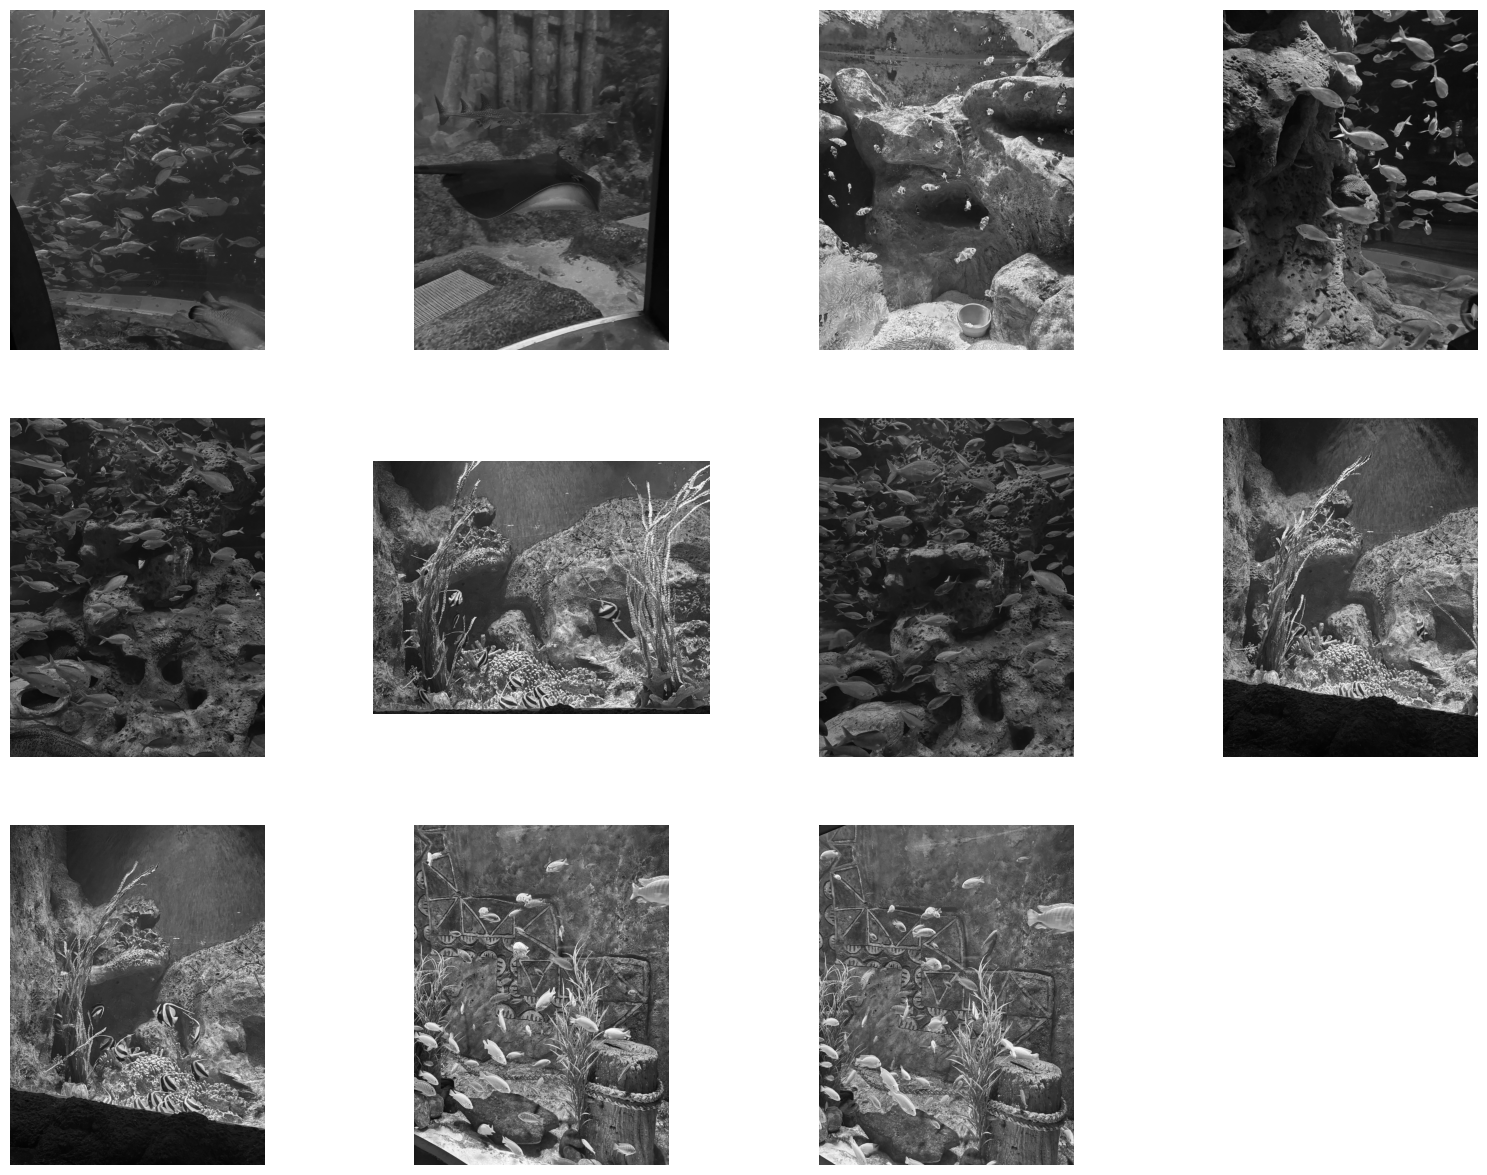

In [12]:
listIMG = getListImage("IMG")
listIMGGray = convertGray(listIMG)
showListImageGray(listIMGGray)

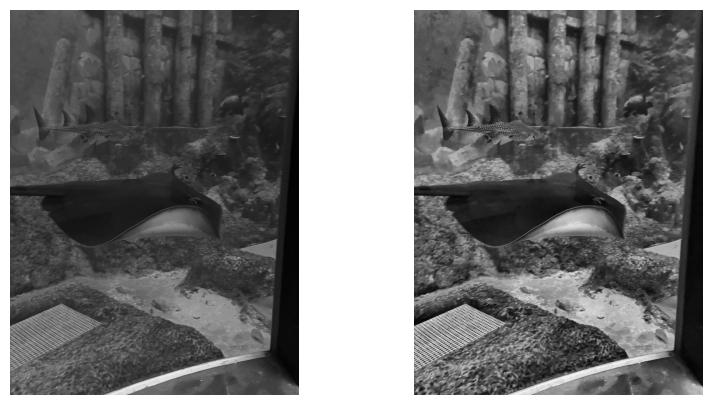

In [13]:
imgHist = histogram_clahe(listIMGGray[1])
imgs = []
imgs.append(listIMGGray[1])
imgs.append(imgHist)
showListImageGray(imgs)

In [14]:
def sharpen_kernel(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel)
    return sharpened


In [16]:
#Hàm truyền vào ảnh grayCale để phân tích độ sáng tb
def analyze_img(img):
    mean_brightness =np.mean(img)
    contrast = np.std(img)
    return mean_brightness, contrast


In [26]:
#hàm xử lý cho ảnh y tế
def processing_CLAHE_Log(gray, method):
    #Chuyển ảnh sáng grayScale
    if gray.ndim == 3:  # ảnh màu
        gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
    img_CLAHE = histogram_clahe(gray)
    if method == "gamma":
        result = convertByPowerLawOne(img_CLAHE, 0.7, 5)
        result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    elif method == "log":
        result = convert_LogarithmOne(img_CLAHE, 40)
        result = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    else: result = img_CLAHE
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(gray, cmap= 'gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(result, cmap= 'gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()

In [19]:
#hàm xủ lý ảnh thiếu ánh sáng
def proccessing_lack_of_light(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gamma = convertByPowerLawOne(img, 0.4, 7)
    result = histogram_clahe(img_gamma.astype(np.uint8))
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap= 'gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(result, cmap= 'gray')
    plt.axis('off')
    plt.show()


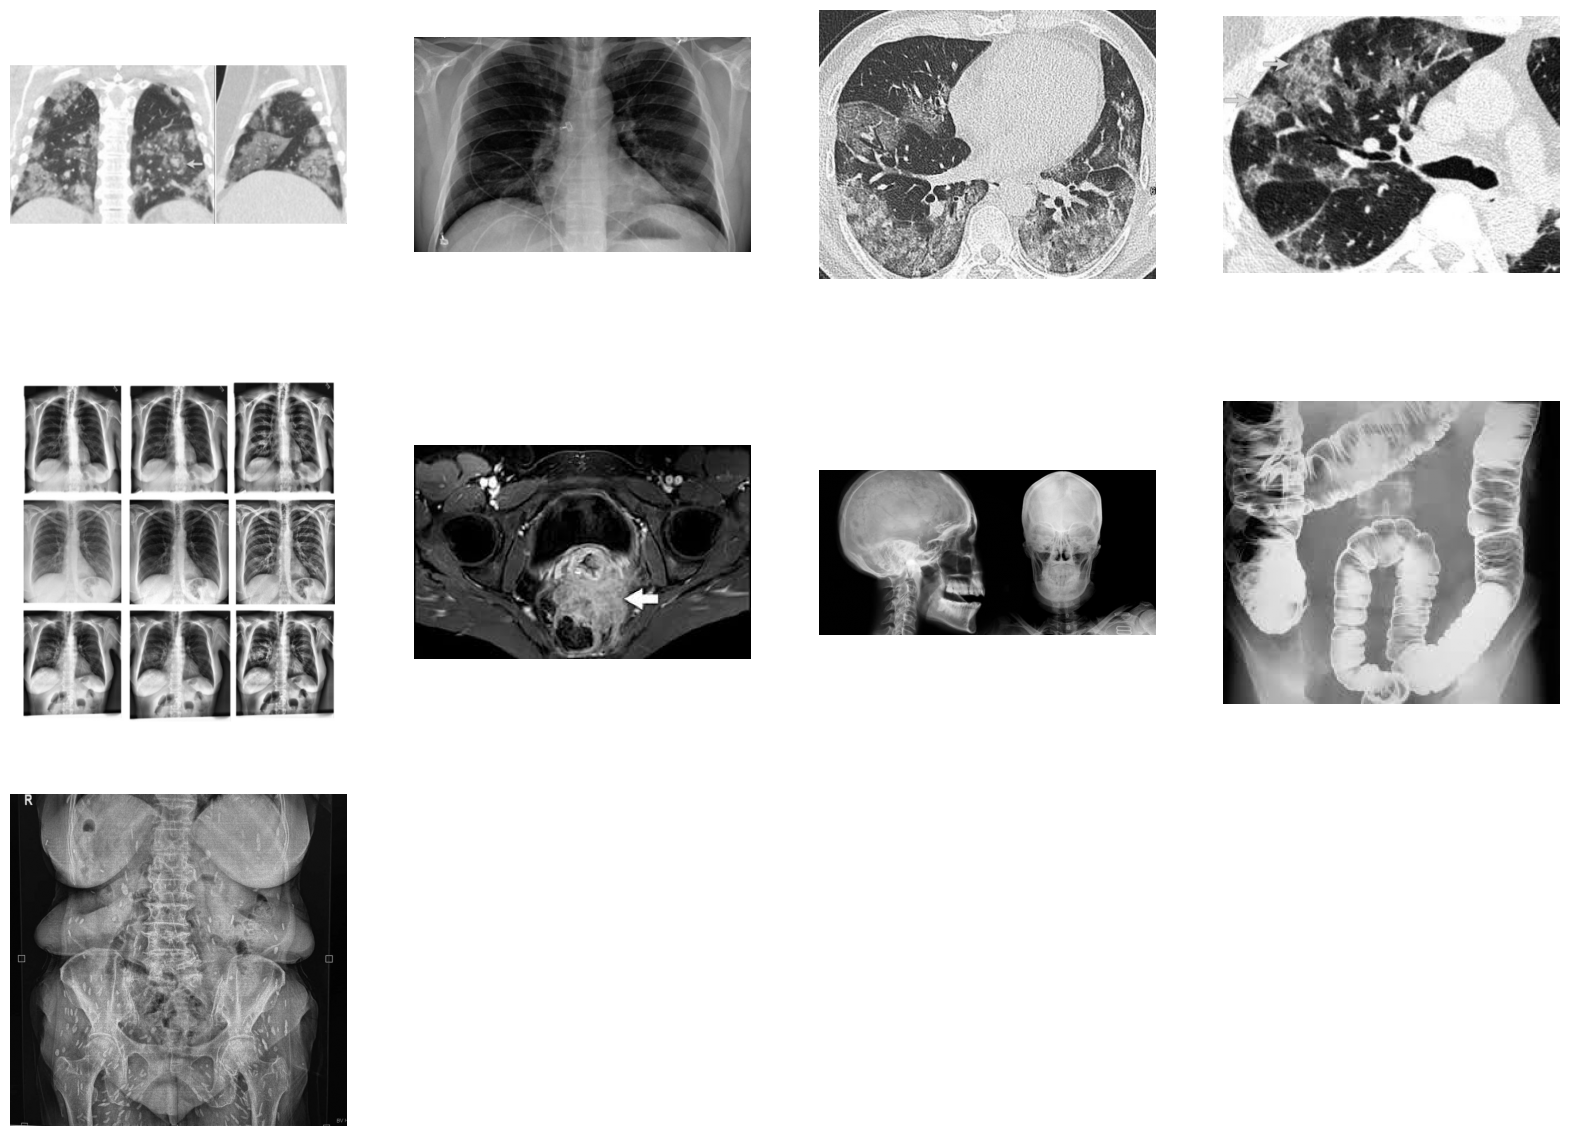

In [30]:
listImg= getListImage("IMG_AnhYTe")
listImggray = convertGray(listImg)
showListImageGray(listImggray)

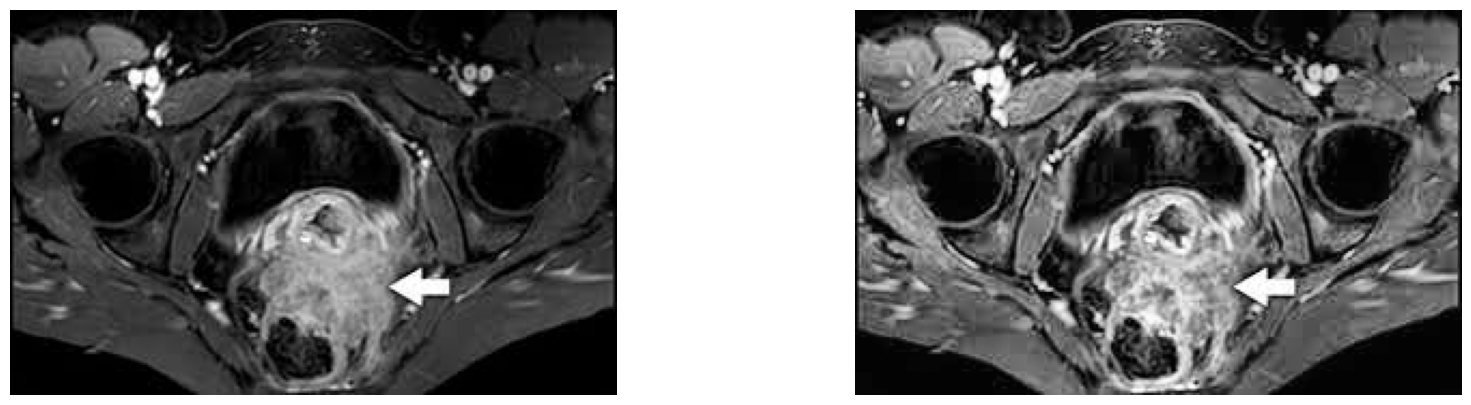

In [36]:
processing_CLAHE_Log(listImggray[5], 'other')

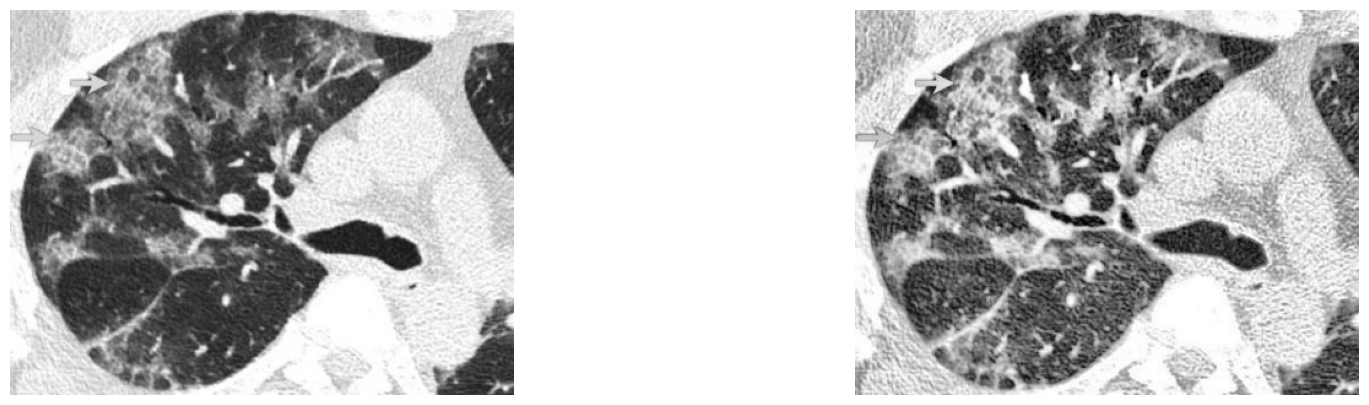

In [50]:
processing_CLAHE_Log(listImggray[3], 'gamma')

0 uint8 (536, 800, 3) 0 23
1 uint8 (768, 1024, 3) 0 255
2 uint8 (450, 800, 3) 0 255
3 uint8 (399, 600, 3) 0 255
4 uint8 (1365, 2048, 3) 0 255
5 uint8 (197, 255, 3) 0 255
6 uint8 (183, 275, 3) 0 49
7 uint8 (400, 600, 3) 0 255
8 uint8 (800, 1200, 3) 0 255
9 uint8 (1151, 768, 3) 0 255
10 uint8 (1000, 1500, 3) 6 255
11 uint8 (2560, 1706, 3) 0 255
12 uint8 (2560, 1706, 3) 0 255
13 uint8 (2560, 1706, 3) 0 255


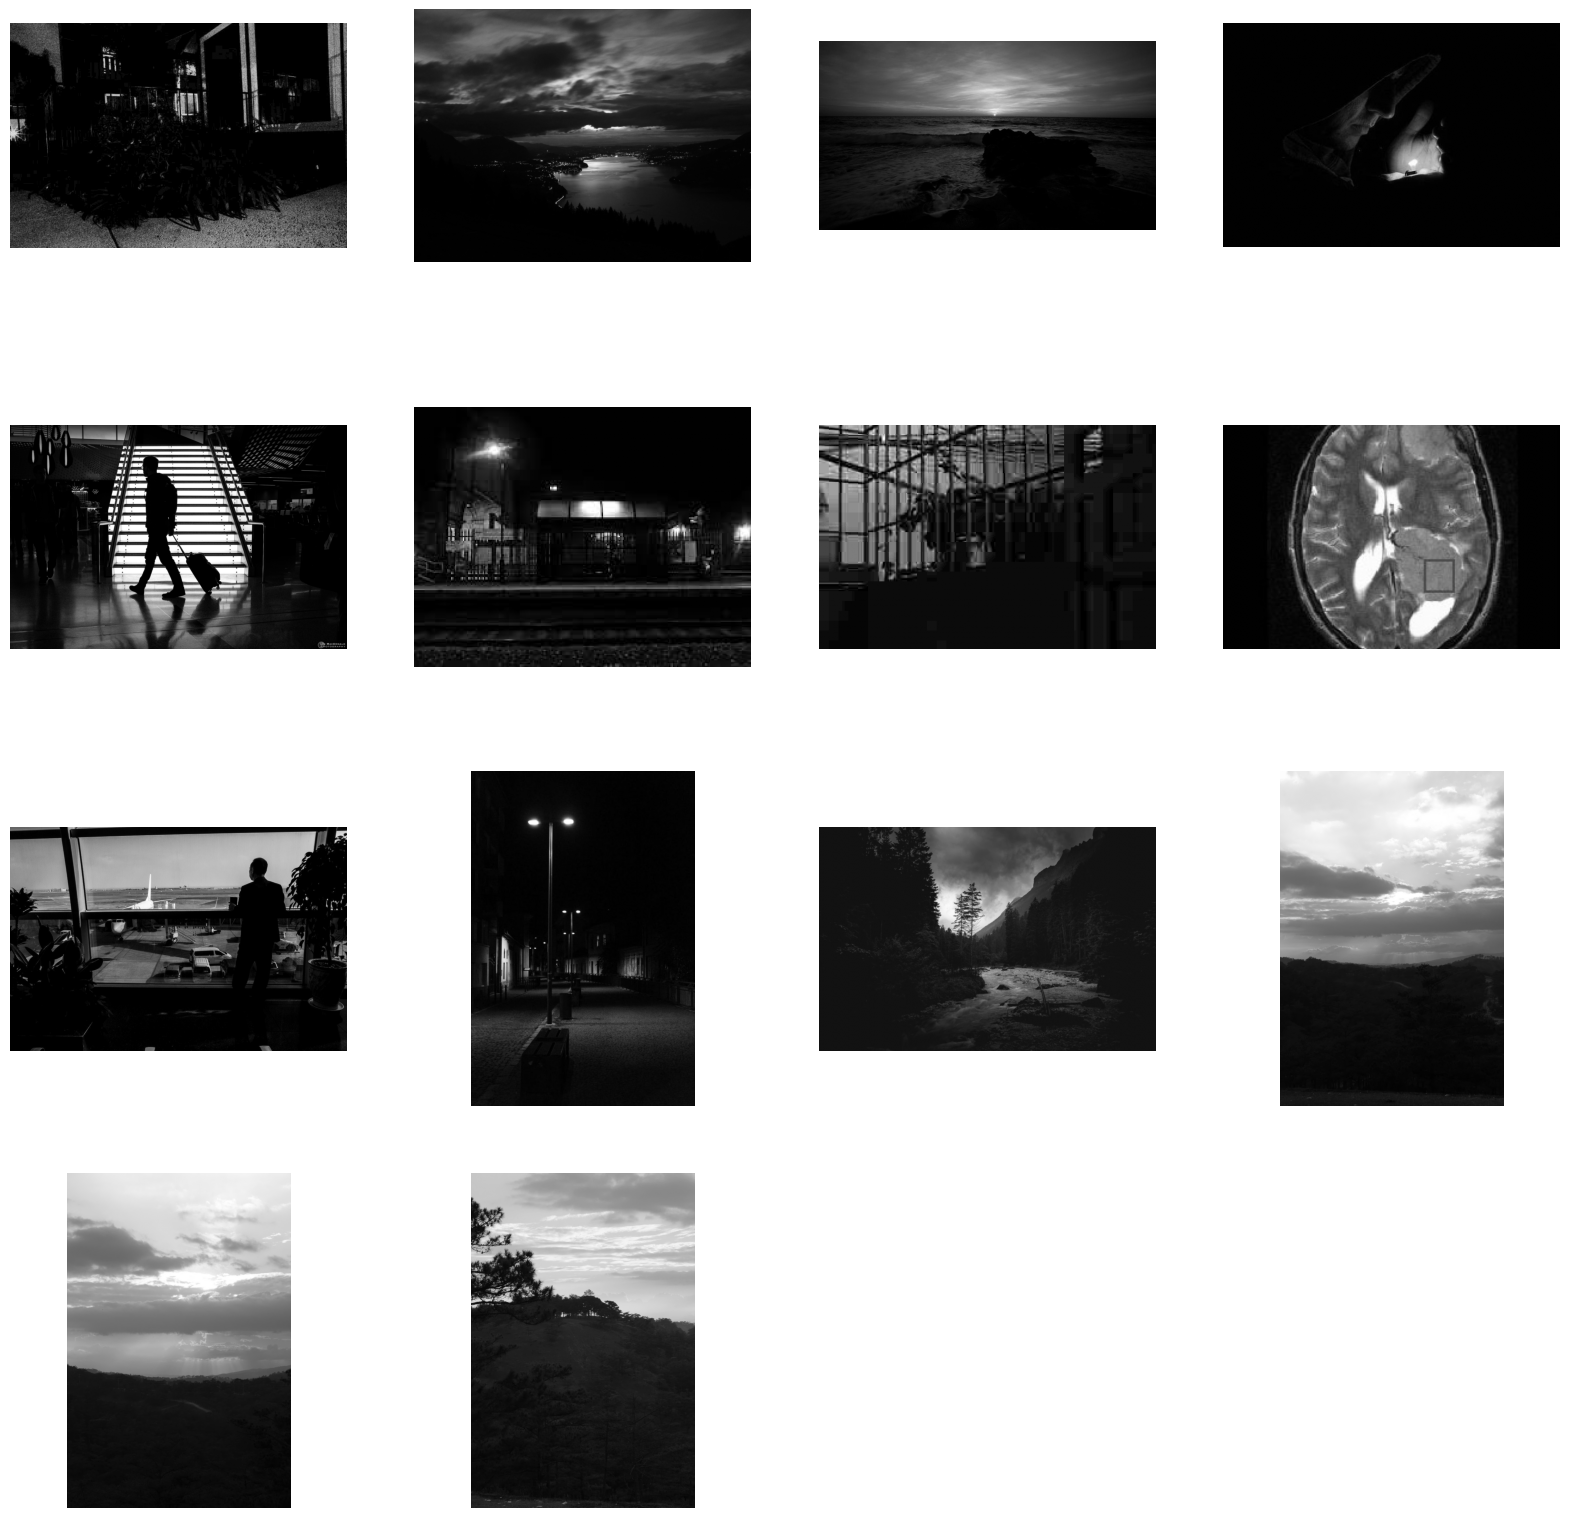

In [28]:
listTest = getListImage("IMG_test")
for idx, img in enumerate(listTest):
    print(idx, img.dtype, img.shape, img.min(), img.max())
listTestGray = convertGray(listTest)
showListImageGray(listTestGray)

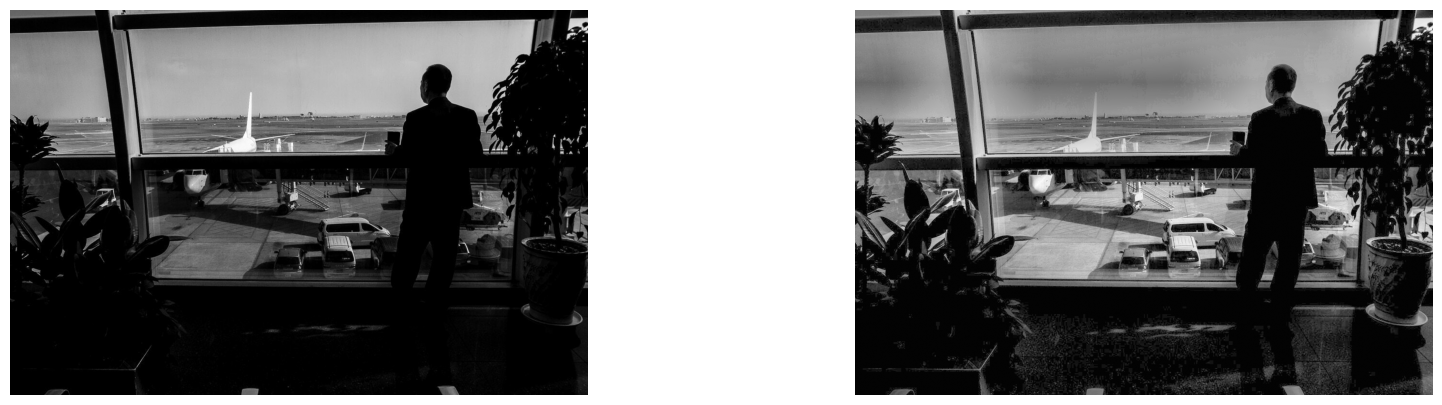

In [29]:
proccessing_lack_of_light(listTestGray[8])